<img src="img/Logo_OpenClassrooms.png" width=100 />

# OpenClassrooms Projet 5: Segmentez des clients d'un site e-commerce
# Modélisation

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

### Les données
Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

### Votre mission
Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

- La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
- Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
- Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.


# Sommaire
### [Bibliothèques](#bibli)
### [Fonctions](#funcs)
### [Données](#donnees)
### [Centrage des données](#scaling)
### [Analyse en composantes principales](#PCA)
### [t-SNE](#tsne)
### [k-Means](#kmeans)
- [concordance k-Means, t-SNE](#concordance)

### [Tuning t-SNE](#tuning_tsne)

<a id='bibli'></a>
# Import de bibliothèques 📚

In [94]:
import pandas as pd
pd.set_option("mode.chained_assignment", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# matplotlib setup 
plt.style.use('seaborn')
plt.rcParams["image.cmap"] = 'Accent'

from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
from sklearn import manifold
from sklearn.cluster import KMeans, DBSCAN
from sklearn import metrics

import mlflow

import time

<a id='funcs'></a>

# Fonctions ⚙️

In [87]:
def scree_plot(data_scale, savefig=False):
    pca_scree = decomposition.PCA(n_components=data_scale.shape[1])
    pca_scree.fit(data_scale)
    plt.style.use('seaborn')
    plt.xlabel('Nb de Composantes Principales')
    plt.ylabel('Pourcentage de variance expliquée (cumulée)')
    plt.title('Scree plot PCA')
    plt.plot(np.arange(1, pca_scree.n_components_ + 1), pca_scree.explained_variance_ratio_.cumsum()*100)
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=720)
    plt.show()

<a id='plot_spyder'></a>

In [2]:
def plot_spyder(pca, feature_names, lim=0.6, savefig=False):
    pcs = pca.components_
    plt.figure(figsize=(12,12))
    for i,(x,y) in enumerate(zip(pcs[0,:], pcs[1,:])):
        plt.plot([0,x], [0,y], color='purple')
        plt.text(x,y, feature_names[i], fontsize='14')
        plt.axis('equal')
    plt.plot([-lim,lim], [0,0], color='grey', ls='--')
    plt.plot([0,0], [-lim,lim], color='grey', ls='--')
    plt.xlim([-lim,lim])
    plt.ylim([-lim,lim])
    plt.title('Spyder Plot')
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=360)
    plt.show()

<a id='plot_scatter_tsne'></a>

In [3]:
def plot_scatter_tsne(data_tsne, loaded_model, data_scale, savefig=False):
    """Create figure with 2d projected data by tsne colored 
    by labels predicted by a kmeans model"""
    x = [point[0] for point in data_tsne]
    y = [point[1] for point in data_tsne]

    fig, ax = plt.subplots(figsize=(8,8))
    plt.axis('equal')
    plt.rcParams["image.cmap"] = 'Accent'
    scatter = ax.scatter(x, y, marker='o', s=15, c=loaded_model.predict(pd.DataFrame(data_scale)))
    legend1 = plt.legend(*scatter.legend_elements(),
                         loc="best", title="Classes", fontsize=12)
    ax.add_artist(legend1)
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=360)
    plt.show()
    print(tsne.kl_divergence_)

In [4]:
def plot_scatter_tsne_seaborn(data_tsne, loaded_model, data_scale, savefig=False):
    """Create figure with 2d projected data by tsne colored 
    by labels predicted by a kmeans model"""
    
    df_subset = pd.DataFrame(data=data_tsne, columns=['x', 'y'])
    plt.figure(figsize=(8,8))
    plt.rcParams["image.cmap"] = 'Accent'
    print(len(set(list(loaded_model.predict(pd.DataFrame(data_scale))))))
    plt.axis('equal')
    sns.scatterplot(x="x", 
                    y="y",
                    s=15,
                    hue=loaded_model.predict(pd.DataFrame(data_scale)),
                    palette=sns.color_palette("hls", len(set(list(loaded_model.predict(pd.DataFrame(data_scale)))))),
                    data=df_subset,
                    legend="full")
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=360)
    plt.show()
    print(tsne.kl_divergence_)

Retour au [code](#plot_scatter_tsne_back)

<a id='plot_perplexity_tsne'></a>

In [5]:
def plot_perplexity_tsne(tsne_data_save, loaded_model, color_from_labels=False, savefig=False):
    """"""
    fig, axes = plt.subplots(2,5, figsize=(25,10))
    axs = {5 : axes[0,0],
           10: axes[0,1],
           15: axes[0,2],
           20: axes[0,3],
           25: axes[0,4],
           30: axes[1,0],
           35: axes[1,1],
           40: axes[1,2],
           45: axes[1,3],
           50: axes[1,4]}
    for perplexity in np.arange(5,55,5):
        data_tsne_test = tsne_data_save[perplexity]
        df_subset = pd.DataFrame(data=data_tsne_test, columns=['x', 'y'])
        x = [point[0] for point in data_tsne_test]
        y = [point[1] for point in data_tsne_test]
        ax = axs[perplexity]
        ax.axis('equal')
        if color_from_labels:
            sns.scatterplot(ax=ax,
                            s=10,
                            x="x", 
                            y="y", 
                            hue=loaded_model.predict(pd.DataFrame(data_scale)),
                            palette=sns.color_palette("hls", len(set(list(loaded_model.predict(pd.DataFrame(data_scale)))))),
                            data=df_subset,
                            legend=False)
        else:
            ax.scatter(x, y, marker='.', s=10, 
                       color='purple')
        
        ax.set_title("Perplexity = {}".format(perplexity))
        ax.axis('equal')
    if savefig:
        plt.savefig('plots/{}.png'.format(savefig), bbox_inches='tight', dpi=720)
    plt.show()

Retour au [code](#tuning_tsne)

<a id='launch_kmeans'></a>

In [6]:
def launch_kmeans(data, params, run_name):
    
    with mlflow.start_run(run_name=run_name):
        #Create an estimator
        model = KMeans(**params)
        #Save params
        for param, value in model.get_params().items():
            mlflow.log_param(param, value)
        #Fit
        start = time.time()
        model.fit(data)
        elapsed = time.time() - start
        
        
        #Save metrics
        mlflow.log_metric('inertia', model.inertia_)
        mlflow.log_metric('nb_iter', model.n_iter_)
        mlflow.log_metric('training_time', elapsed)
        mlflow.log_metric('silhouette_score', metrics.silhouette_score(data, model.labels_))
        mlflow.log_metric('davies_bouldin_score', metrics.davies_bouldin_score(data, model.labels_))
        
        
        #Save model
        mlflow.sklearn.log_model(model, "model")
        
        mlflow.end_run()

Retour au [code](#kmeans)

<a id='donnees'></a>

# Données 🎁

<img src="img/structure.png" width=500 />

Les données ont été travaillées pour etre rassemblées dans une base propre ayant pour index les ids des clients ayant fait 2 commandes ou plus. Les varaiables ont été crées pour représenter leurs comportemenst, leur satisfactions et leurs expériences

In [7]:
data = pd.read_csv("data/customer_data.csv", index_col=[0])

In [8]:
data.head()

,nb_orders,days_since_first_order,days_since_last_order,frequency,sum_orders,nb_reviews,average_review_score,average_delivery_time,delay_rate,advance_rate,...,stationery,tablets_printing_image,telephony,tools,toys,watches_gifts,cash,credit_card,debit_card,voucher
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
00172711b30d52eea8b313a7f2cced02,2,81,65,0.751543,74.50,2.0,4.0,11,0.0,1.0,...,1,0,0,0,0,0,0,0,0,1
004288347e5e88a27ded2bb23747066c,2,447,276,0.136186,317.89,2.0,5.0,7,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
004b45ec5c64187465168251cd1c9c2f,2,411,143,0.148114,86.90,2.0,3.0,22,0.0,1.0,...,0,0,0,1,0,0,1,0,0,0
0058f300f57d7b93c477a131a59b36c3,2,240,208,0.253646,132.48,2.0,3.0,13,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
00a39521eb40f7012db50455bf083460,2,146,136,0.416952,81.45,2.0,4.0,18,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [9]:
data.shape

(2997, 51)

In [10]:
data.columns

Index(['nb_orders', 'days_since_first_order', 'days_since_last_order',
       'frequency', 'sum_orders', 'nb_reviews', 'average_review_score',
       'average_delivery_time', 'delay_rate', 'advance_rate',
       'cancelation_rate', 'air_conditioning', 'appliances',
       'arts_and_craftmanship', 'audio', 'auto', 'baby', 'books',
       'christmas_supplies', 'cine_photo', 'computers', 'consoles_games',
       'cool_stuff', 'diapers_and_hygiene', 'dvds_blu_ray', 'electronics',
       'fashion', 'food_drink', 'furniture', 'health_beauty', 'home_confort',
       'home_construction', 'housewares', 'industry', 'luggage_accessories',
       'market_place', 'music', 'other', 'pet_shop', 'signaling_and_security',
       'sports_leisure', 'stationery', 'tablets_printing_image', 'telephony',
       'tools', 'toys', 'watches_gifts', 'cash', 'credit_card', 'debit_card',
       'voucher'],
      dtype='object')

In [11]:
cols_numeric = data.loc[:,:'cancelation_rate'].columns
cols_categ = data.loc[:,'air_conditioning':].columns

<a id='scaling'></a>
# Centrage des données 📊

D'après la théorie de l'analyse en composante principale, pour pouvoir projeter nos données dans une base orthonormée de plus faible dimension alors la matrice des données doit être normée elle aussi

In [12]:
scaler = StandardScaler()

In [13]:
scaler.fit(data[cols_numeric])

StandardScaler()

In [14]:
scaler.transform(data[cols_numeric]).shape

(2997, 11)

In [15]:
data_scale = pd.concat([pd.DataFrame(data=scaler.transform(data[cols_numeric]), index=data.index, columns=cols_numeric), data[cols_categ]], axis=1)

In [16]:
data_scale

,nb_orders,days_since_first_order,days_since_last_order,frequency,sum_orders,nb_reviews,average_review_score,average_delivery_time,delay_rate,advance_rate,...,stationery,tablets_printing_image,telephony,tools,toys,watches_gifts,cash,credit_card,debit_card,voucher
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
00172711b30d52eea8b313a7f2cced02,-0.224803,-1.852280,-1.398262,3.087087,-0.600943,-0.389069,-0.085903,-0.131181,-0.300228,0.398466,...,1,0,0,0,0,0,0,0,0,1
004288347e5e88a27ded2bb23747066c,-0.224803,0.617311,0.053624,-0.585370,0.188105,-0.389069,0.783741,-0.691820,-0.300228,0.398466,...,0,0,0,0,0,0,0,1,0,0
004b45ec5c64187465168251cd1c9c2f,-0.224803,0.374401,-0.861546,-0.514179,-0.560744,-0.389069,-0.955547,1.410577,-0.300228,0.398466,...,0,0,0,1,0,0,1,0,0,0
0058f300f57d7b93c477a131a59b36c3,-0.224803,-0.779425,-0.414282,0.115633,-0.412978,-0.389069,-0.955547,0.149139,-0.300228,0.398466,...,0,0,0,0,0,0,0,0,0,1
00a39521eb40f7012db50455bf083460,-0.224803,-1.413691,-0.909712,1.090245,-0.578412,-0.389069,-0.085903,0.849938,-0.300228,0.398466,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff36be26206fffe1eb37afd54c70e18b,1.711215,-1.852280,-1.467072,5.329693,-0.589921,1.027748,-0.955547,0.008979,-0.300228,-3.952728,...,0,0,0,0,0,0,0,0,0,1
ff44401d0d8f5b9c54a47374eb48c1b8,-0.224803,1.076142,1.698178,-0.692685,-0.713438,-0.389069,-0.955547,0.008979,-0.300228,0.398466,...,0,0,0,0,0,0,0,0,0,1
ff8892f7c26aa0446da53d01b18df463,-0.224803,1.049152,0.383911,-0.687163,0.058623,1.027748,-1.245428,3.512974,2.654544,-1.777131,...,0,0,0,0,0,1,0,1,0,0


<a id='PCA'></a>
# Analyse en composantes principales ☘️

Sans les données catégoriques

In [17]:
pca_simple = decomposition.PCA(n_components=3)
pca_simple.fit(data_scale[cols_numeric])
print(pca_simple.explained_variance_ratio_.cumsum())

[0.23364062 0.45150694 0.61880425]


Avec les données catégoriques

In [18]:
pca = decomposition.PCA(n_components=3)
pca.fit(data_scale)
print(pca.explained_variance_ratio_.cumsum())

[0.20835307 0.4027918  0.55198789]


On explique 55% de la variance avec trois composantes principales

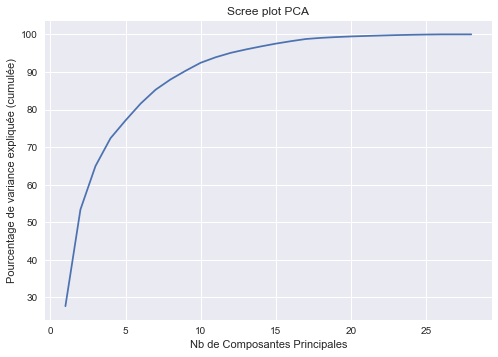

In [88]:
scree_plot(data_scale, savefig='scree_plot')

Voir la [fonction plot_spyder](#plot_spyder)

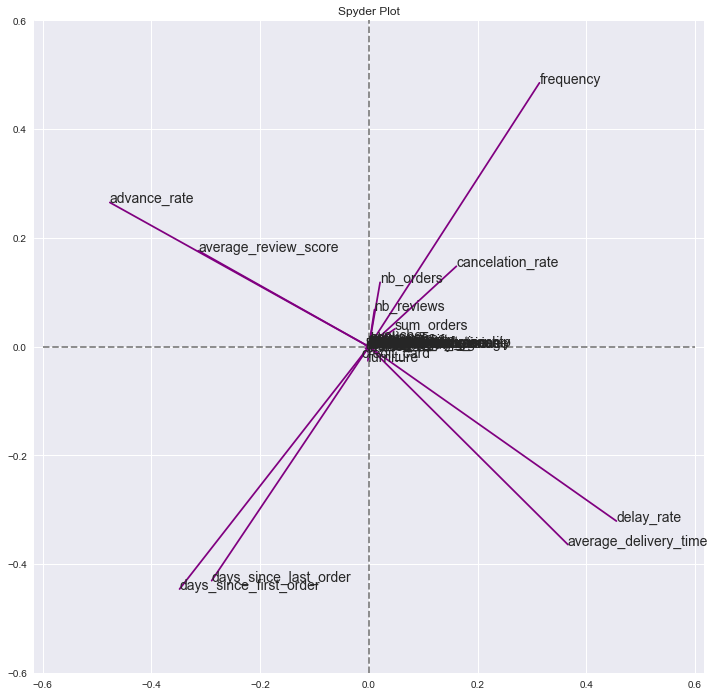

In [20]:
plot_spyder(pca, data_scale.columns, lim=0.6, savefig='spyder_plot_pca')

Retirer les features nb_orders, nb_reviews, sum_orders. On verra plus tard pour les catégories

<a id='tsne'></a>
# t-SNE ✨

Données non standardisées

In [21]:
%%time
tsne_raw = manifold.TSNE(random_state=41)
data_tsne_raw = tsne_raw.fit_transform(data)

Wall time: 10.1 s


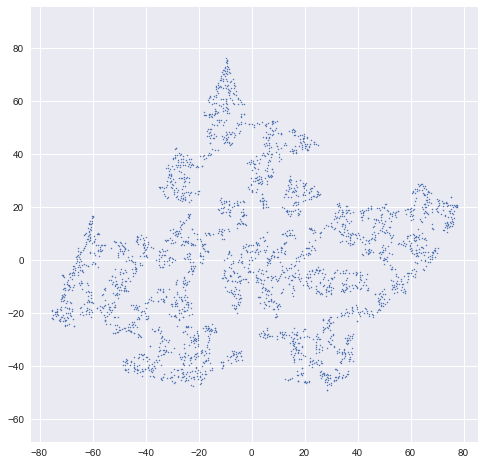

0.8501572012901306


In [22]:
x = [point[0] for point in data_tsne_raw]
y = [point[1] for point in data_tsne_raw]
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='.', s=5)
plt.show()
print(tsne_raw.kl_divergence_)

Données Standardisées

In [23]:
%%time
tsne = manifold.TSNE(init='pca', random_state=41, n_jobs=-1)
data_tsne = tsne.fit_transform(data_scale)

Wall time: 11.8 s


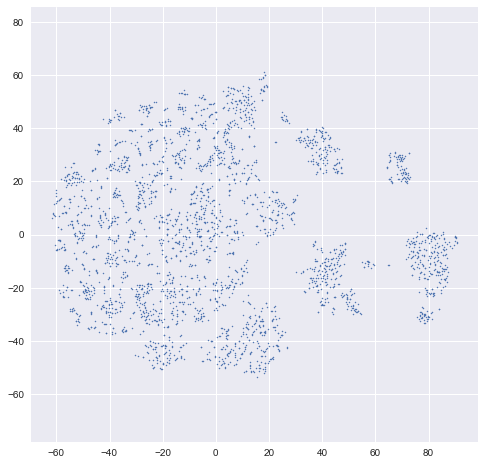

1.30453360080719


In [24]:
x = [point[0] for point in data_tsne]
y = [point[1] for point in data_tsne]
plt.style.use('seaborn')
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='.', s=5)
plt.show()
print(tsne.kl_divergence_)

On voit bien ici l'intéret de travailler sur des données standardisées

Fit un kmeans et colorier les points avec les etiquettes du kmeans et vérifier la cohérence du t-sne vis à vis du kmeans. Ensuite essayer la perplexité

<a id='kmeans'></a>
# k-Means 🧶

mlflow.set_experiment('k_Means')
for n_clusters in np.arange(19,26):
    launch_kmeans(data_scale, {'n_clusters':n_clusters, 'random_state':41}, 'GS_sil_db{}'.format(n_clusters))

Voir la [fonction](#launch_kmeans)

In [25]:
runs = mlflow.search_runs('1')

In [26]:
runs[runs['tags.mlflow.runName']!='test'][['tags.mlflow.runName', 'params.n_clusters', 'metrics.inertia', 'metrics.silhouette_score']].sort_values('metrics.silhouette_score', ascending=False)

,tags.mlflow.runName,params.n_clusters,metrics.inertia,metrics.silhouette_score
32,GS_sil_2,2,31150.634832,0.369910
23,GS_sil_db2,2,31150.634832,0.369910
29,GS_sil_5,5,21633.441276,0.193952
20,GS_sil_db5,5,21633.441276,0.193952
30,GS_sil_4,4,24247.857397,0.189334
...,...,...,...,...
228,GS_5,5,21633.441276,NaN
229,GS_4,4,24247.857397,NaN
230,GS_3,3,26977.036396,NaN
231,GS_2,2,31150.634832,NaN


In [27]:
runs.artifact_uri.iloc[0] + '/model'

'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/618a8111a0c54a999e258e3b3f7934b4/artifacts/model'

<a id='concordance'></a>
## Concordance k-Means avec t-SNE 🧬

### Avec 5 clusters

In [28]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/c9520ad7bef0449d81f2c0b697be3a2a/artifacts/model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

<a id='plot_scatter_tsne_back'></a>

5


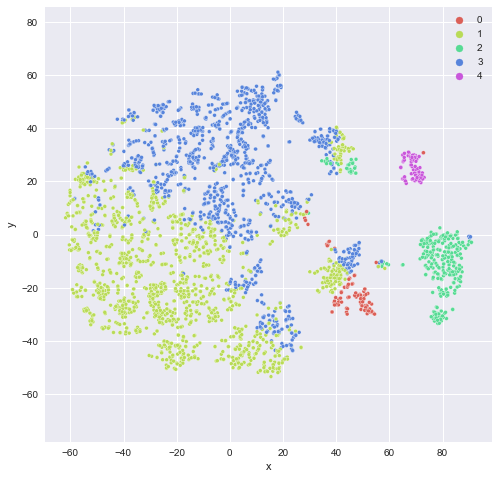

1.30453360080719


In [30]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model, data_scale)  

Voir [fonction](#plot_scatter_tsne)

### Avec 2 clusters

In [31]:
logged_model_2 = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/af4f2361d4744d7598403f4e0067f92c/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_2 = mlflow.pyfunc.load_model(logged_model_2)


2


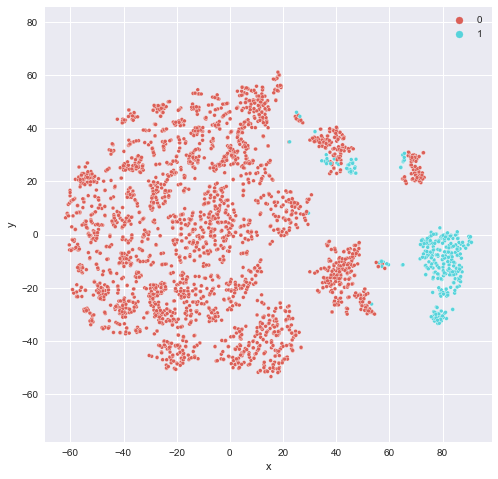

1.30453360080719


In [33]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_2, data_scale)    

### Avec 10 clusters

In [34]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/7e84e7aff2a24088bcec17d3813f9dd8/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_10 = mlflow.pyfunc.load_model(logged_model)

10


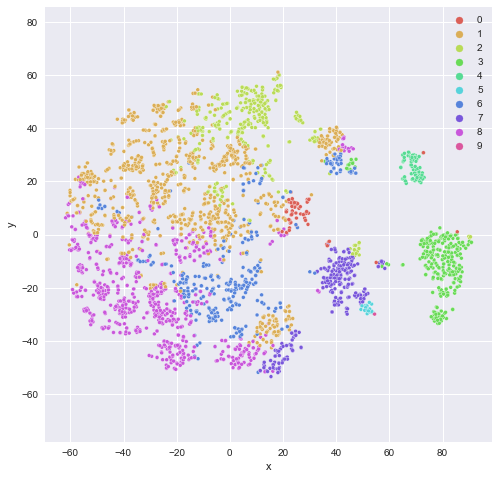

1.30453360080719


In [36]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_10, data_scale)   

### Avec 11 clusters

In [37]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/376fbc189978476ea81ffcbc153a5b03/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_11 = mlflow.pyfunc.load_model(logged_model)

11


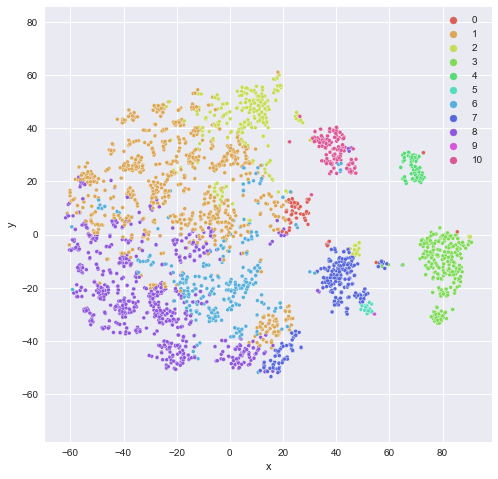

1.30453360080719


In [38]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_11, data_scale)    

### Avec 15 clusters

In [39]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/1/9eab375a8ce2445fa75c3ae087d4bcf5/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_15 = mlflow.pyfunc.load_model(logged_model)

15


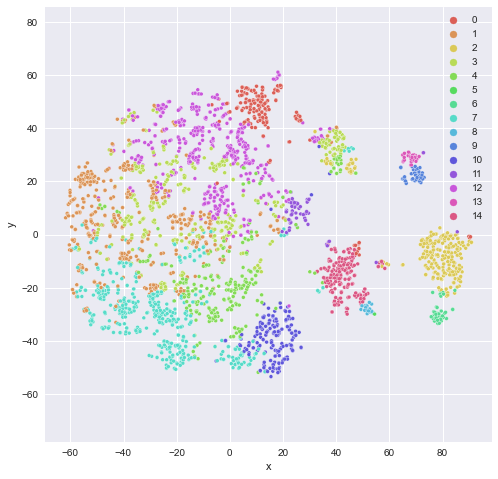

1.30453360080719


In [41]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_15, data_scale)    

<a id='tuning_tsne'></a>
# Tentative d'amélioration du t-SNE

Nous allons visuellement tuner la perplexité de t-SNE en tracant les projections

In [42]:
tsne_data_save = {}
for perplexity in np.arange(5,55,5):
    tsne_test = manifold.TSNE(init='pca', 
                              random_state=41, 
                              n_jobs=-1, 
                              perplexity=perplexity)
    data_tsne_test = tsne_test.fit_transform(data_scale)
    tsne_data_save[perplexity] = data_tsne_test

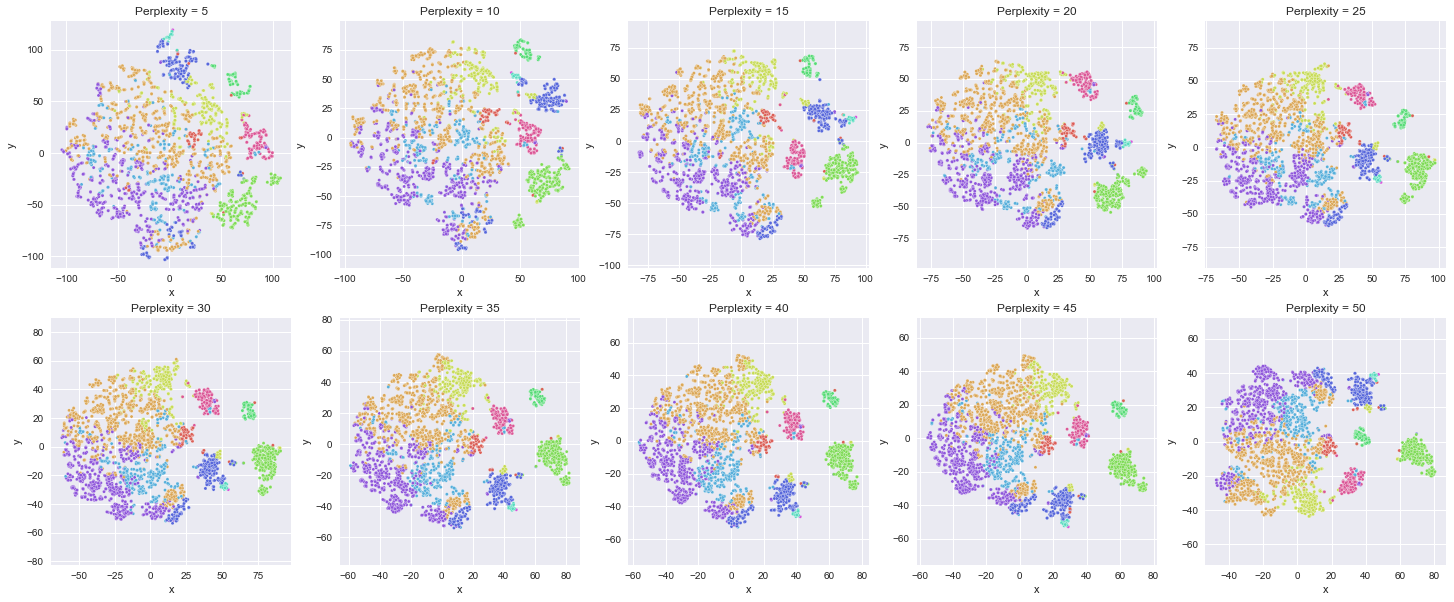

In [43]:
plot_perplexity_tsne(tsne_data_save,
                     loaded_model_11,
                     color_from_labels=True)

Voir la [fonction](#plot_perplexity_tsne)


Les resultats sont peu satisfaisants même si on en a appris un peu sur nos données. Nous allons refaire l'étude avec une version des données ayant une plus petite dimension. Nous avons retravaillé la donnée "categorie preferee" et diminué sa cardinalité de 36 à 16.

<a id='donnees_2'></a>

# Données 🎁

In [48]:
data = pd.read_csv("data/customer_data_v_2.csv", index_col=[0])

In [49]:
data.head()

,nb_orders,days_since_first_order,days_since_last_order,frequency,sum_orders,nb_reviews,average_review_score,average_delivery_time,delay_rate,advance_rate,...,home_construction,industry,other,pet_shop,sports_leisure,watches_gifts_toys,cash,credit_card,debit_card,voucher
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
00172711b30d52eea8b313a7f2cced02,2,81,65,0.751543,74.50,2.0,4.0,11,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
004288347e5e88a27ded2bb23747066c,2,447,276,0.136186,317.89,2.0,5.0,7,0.0,1.0,...,0,0,0,0,0,1,0,1,0,0
004b45ec5c64187465168251cd1c9c2f,2,411,143,0.148114,86.90,2.0,3.0,22,0.0,1.0,...,1,0,0,0,0,0,1,0,0,0
0058f300f57d7b93c477a131a59b36c3,2,240,208,0.253646,132.48,2.0,3.0,13,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
00a39521eb40f7012db50455bf083460,2,146,136,0.416952,81.45,2.0,4.0,18,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0


In [50]:
data.shape

(2997, 31)

D'après le premier spyder plot, certaines colonnes n'apportent pas grand chose à notre problématique de clustering

In [51]:
data.drop(columns=['nb_orders', 'nb_reviews', 'sum_orders'], inplace=True)

In [52]:
data.columns

Index(['days_since_first_order', 'days_since_last_order', 'frequency',
       'average_review_score', 'average_delivery_time', 'delay_rate',
       'advance_rate', 'cancelation_rate', 'arts_and_craftmanship', 'auto',
       'baby', 'culture', 'electronics', 'fashion', 'food_drink', 'furniture',
       'health_beauty', 'home_confort', 'home_construction', 'industry',
       'other', 'pet_shop', 'sports_leisure', 'watches_gifts_toys', 'cash',
       'credit_card', 'debit_card', 'voucher'],
      dtype='object')

In [53]:
cols_numeric = data.loc[:,:'cancelation_rate'].columns
cols_categ = data.loc[:,'arts_and_craftmanship':].columns

<a id='scaling_2'></a>
# Centrage des données 📊

D'après la théorie de l'analyse en composante principale, pour pouvoir projeter nos données dans une base orthonormée de plus faible dimension alors la matrice des données doit être normée elle aussi

In [54]:
scaler = StandardScaler()

In [55]:
scaler.fit(data[cols_numeric])

StandardScaler()

In [56]:
scaler.transform(data[cols_numeric]).shape

(2997, 8)

In [57]:
data_scale = pd.concat([pd.DataFrame(data=scaler.transform(data[cols_numeric]), index=data.index, columns=cols_numeric), data[cols_categ]], axis=1)

In [58]:
data_scale

,days_since_first_order,days_since_last_order,frequency,average_review_score,average_delivery_time,delay_rate,advance_rate,cancelation_rate,arts_and_craftmanship,auto,...,home_construction,industry,other,pet_shop,sports_leisure,watches_gifts_toys,cash,credit_card,debit_card,voucher
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
00172711b30d52eea8b313a7f2cced02,-1.852280,-1.398262,3.087087,-0.085903,-0.131181,-0.300228,0.398466,5.672887,1,0,...,0,0,0,0,0,0,0,1,0,0
004288347e5e88a27ded2bb23747066c,0.617311,0.053624,-0.585370,0.783741,-0.691820,-0.300228,0.398466,-0.164253,0,0,...,0,0,0,0,0,1,0,1,0,0
004b45ec5c64187465168251cd1c9c2f,0.374401,-0.861546,-0.514179,-0.955547,1.410577,-0.300228,0.398466,-0.164253,0,0,...,1,0,0,0,0,0,1,0,0,0
0058f300f57d7b93c477a131a59b36c3,-0.779425,-0.414282,0.115633,-0.955547,0.149139,-0.300228,0.398466,5.672887,1,0,...,0,0,0,0,0,0,0,0,0,1
00a39521eb40f7012db50455bf083460,-1.413691,-0.909712,1.090245,-0.085903,0.849938,-0.300228,0.398466,-0.164253,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff36be26206fffe1eb37afd54c70e18b,-1.852280,-1.467072,5.329693,-0.955547,0.008979,-0.300228,-3.952728,7.618601,0,0,...,0,0,0,0,0,0,0,0,0,1
ff44401d0d8f5b9c54a47374eb48c1b8,1.076142,1.698178,-0.692685,-0.955547,0.008979,-0.300228,0.398466,-0.164253,0,0,...,0,0,0,0,0,0,0,0,0,1
ff8892f7c26aa0446da53d01b18df463,1.049152,0.383911,-0.687163,-1.245428,3.512974,2.654544,-1.777131,-0.164253,0,0,...,0,0,0,0,0,0,0,1,0,0


<a id='PCA_2'></a>
# Analyse en composantes principales ☘️

Sans les données catégoriques

In [59]:
pca_simple = decomposition.PCA(n_components=3)
pca_simple.fit(data_scale[cols_numeric])
print(pca_simple.explained_variance_ratio_.cumsum())

[0.32080532 0.61867226 0.75233877]


Avec les données catégoriques

In [60]:
pca = decomposition.PCA(n_components=3)
pca.fit(data_scale)
print(pca.explained_variance_ratio_.cumsum())

[0.27671454 0.53391039 0.64953068]


On explique 65% de la variance avec trois composantes principales, c'est une nette amélioration

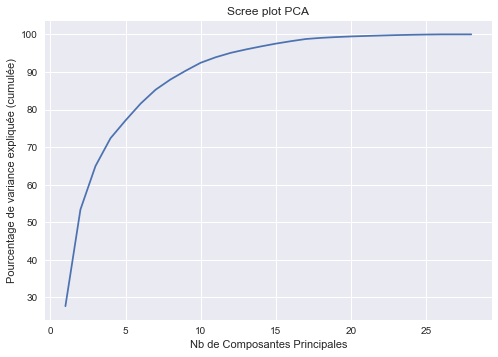

In [89]:
scree_plot(data_scale, savefig='scree_plot_2')

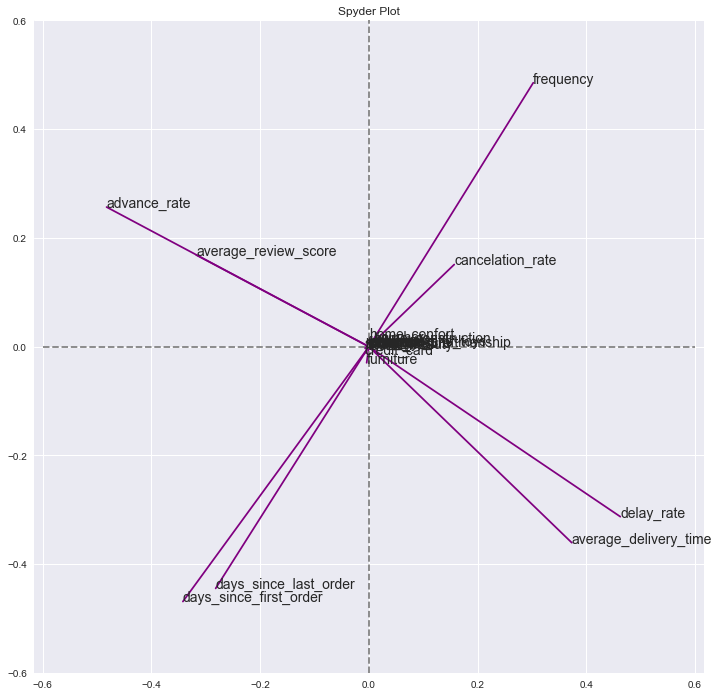

In [63]:
plot_spyder(pca, data_scale.columns, lim=0.6, savefig='spyder_plot_pca_2')

<a id='tsne_2'></a>
# t-SNE ✨

Données non standardisées

In [64]:
%%time
tsne_raw = manifold.TSNE(random_state=41)
data_tsne_raw = tsne_raw.fit_transform(data)

Wall time: 11 s


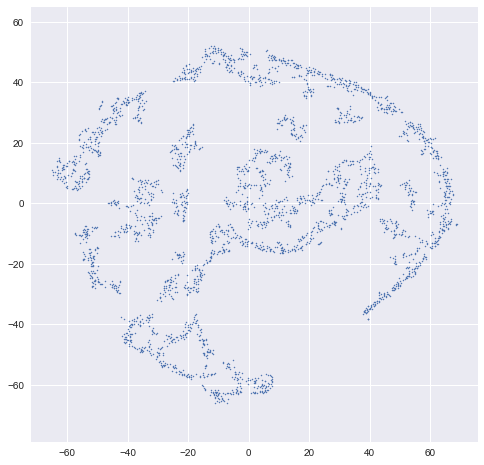

0.5241584777832031


In [65]:
x = [point[0] for point in data_tsne_raw]
y = [point[1] for point in data_tsne_raw]
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='.', s=5)
plt.show()
print(tsne_raw.kl_divergence_)

Données Standardisées

In [66]:
%%time
tsne = manifold.TSNE(init='pca', random_state=41, n_jobs=-1)
data_tsne = tsne.fit_transform(data_scale)

Wall time: 14.2 s


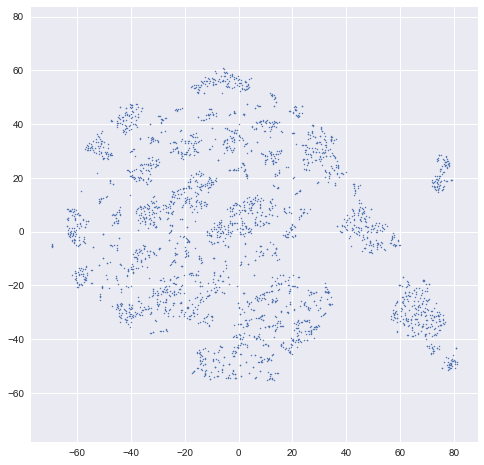

1.132345199584961


In [67]:
x = [point[0] for point in data_tsne]
y = [point[1] for point in data_tsne]
plt.style.use('seaborn')
plt.figure(figsize=(8,8))
plt.axis('equal')
plt.scatter(x, y, marker='.', s=5)
plt.show()
print(tsne.kl_divergence_)

EST CE MIEUX???

<a id='kmeans'></a>
# k-Means 🧶

In [69]:
mlflow.set_experiment('k_Means_2')
for n_clusters in np.arange(2,26):
    launch_kmeans(data_scale, {'n_clusters':n_clusters, 'random_state':41}, 'GS_sil_db{}'.format(n_clusters))

Voir la [fonction](#launch_kmeans)

In [70]:
runs = mlflow.search_runs('3')

In [71]:
runs[runs['tags.mlflow.runName']!='test'][['tags.mlflow.runName', 'params.n_clusters', 'metrics.inertia', 'metrics.silhouette_score']].sort_values('metrics.silhouette_score', ascending=False)

,tags.mlflow.runName,params.n_clusters,metrics.inertia,metrics.silhouette_score
23,GS_sil_db2,2,21968.986587,0.423249
21,GS_sil_db4,4,15101.879364,0.227689
22,GS_sil_db3,3,17814.738844,0.222381
18,GS_sil_db7,7,12108.044977,0.181039
20,GS_sil_db5,5,13678.640477,0.180755
19,GS_sil_db6,6,12746.426180,0.180720
13,GS_sil_db12,12,9701.475832,0.160464
14,GS_sil_db11,11,10215.797406,0.157593
16,GS_sil_db9,9,10980.042781,0.156458
15,GS_sil_db10,10,10599.020244,0.156027


<a id='concordance'></a>
## Concordance k-Means avec t-SNE 🧬

### Avec 4 clusters

In [73]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/3/4d1b1b46e84c465fa04d43b52891acb3/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_v2_4 = mlflow.pyfunc.load_model(logged_model)

<a id='plot_scatter_tsne_back'></a>

4


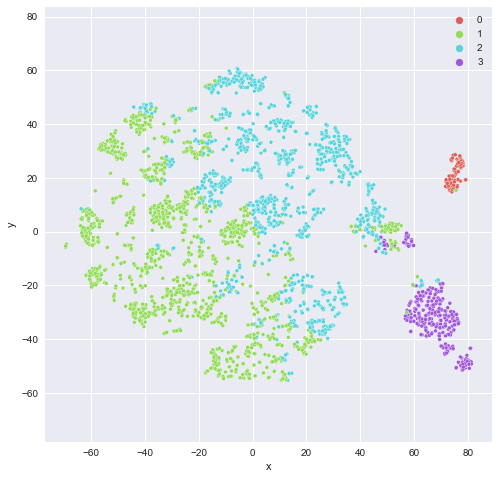

1.132345199584961


In [74]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_v2_4, data_scale)  

Voir [fonction](#plot_scatter_tsne)

### Avec 2 clusters

In [77]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/3/d2fe6b00aa064fa18a02cad79c23ec4a/artifacts/model'


# Load model as a PyFuncModel.
loaded_model_v2_2 = mlflow.pyfunc.load_model(logged_model)


2


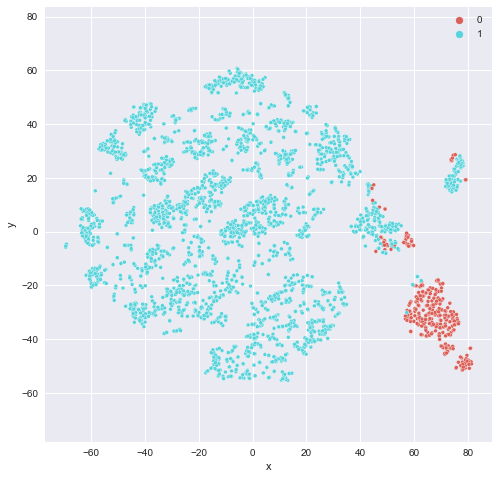

1.132345199584961


In [78]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_v2_2, data_scale)    

### Avec 7 clusters

In [79]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/3/8a5a1158a1a74e69a781c9e2c8ab4206/artifacts/model'

# Load model as a PyFuncModel.
loaded_model_v2_7 = mlflow.pyfunc.load_model(logged_model)

7


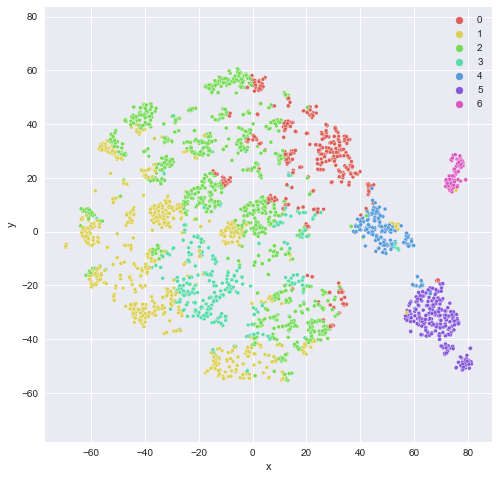

1.132345199584961


In [81]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_v2_7, data_scale)   

### Avec 3 clusters

In [82]:
logged_model = 'file:///C:/Users/S053567/Docs/OpenClassrooms/OC_P05/mlruns/3/5319ccfb58b04be8be46fa3a7753499e/artifacts/model'


# Load model as a PyFuncModel.
loaded_model_v2_3 = mlflow.pyfunc.load_model(logged_model)

3


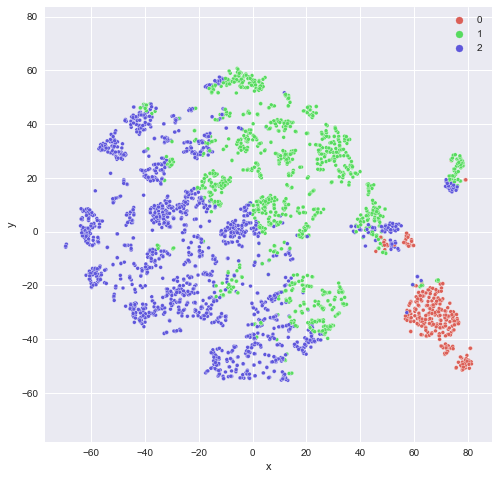

1.132345199584961


In [83]:
plot_scatter_tsne_seaborn(data_tsne, loaded_model_v2_3, data_scale)    

<a id='tuning_tsne_2'></a>
# Tentative d'amélioration du t-SNE

Nous allons visuellement tuner la perplexité de t-SNE en tracant les projections

In [84]:
tsne_data_save = {}
for perplexity in np.arange(5,55,5):
    tsne_test = manifold.TSNE(init='pca', 
                              random_state=41, 
                              n_jobs=-1, 
                              perplexity=perplexity)
    data_tsne_test = tsne_test.fit_transform(data_scale)
    tsne_data_save[perplexity] = data_tsne_test

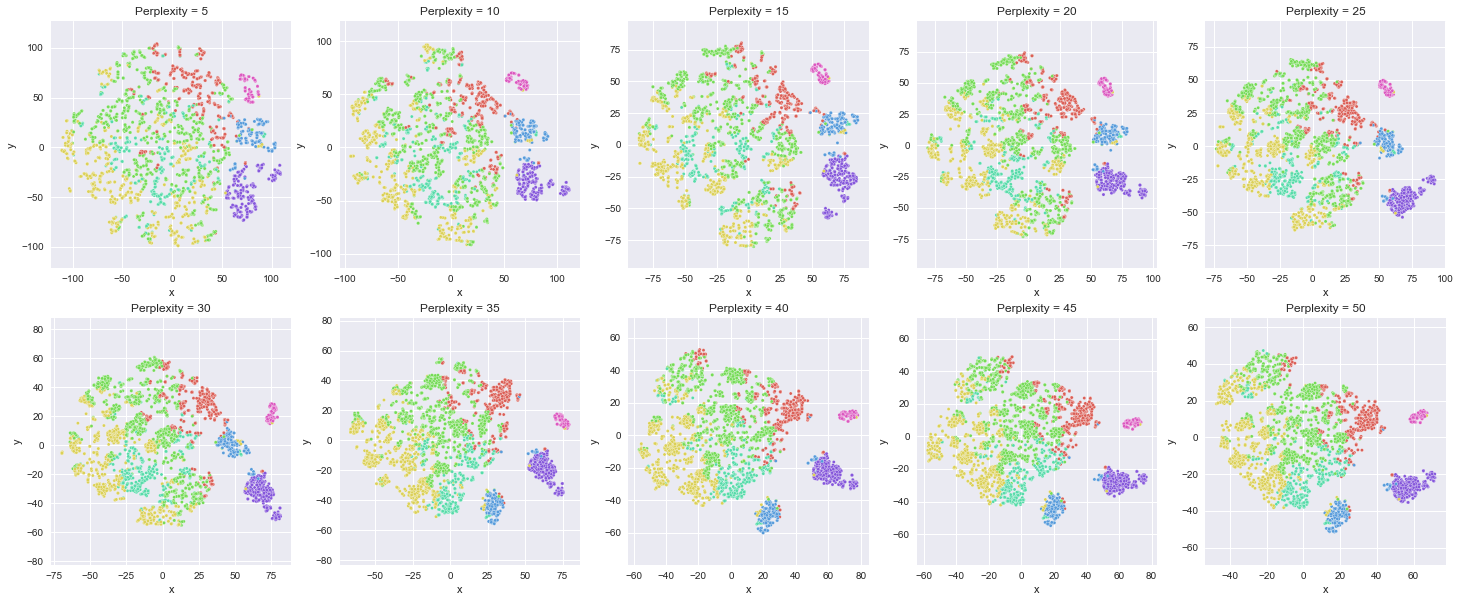

In [86]:
plot_perplexity_tsne(tsne_data_save,
                     loaded_model_v2_7,
                     color_from_labels=True,
                     savefig="perplexity_plots_v2_7")

Voir la [fonction](#plot_perplexity_tsne)


<a id='tuning_tsne_2'></a>
# DBSCAN

In [111]:
def launch_dbscan(data, params, run_name):
    
    for eps in params['eps']:
        for min_samples in params['min_samples']:
            for metric in params['metric']:
                with mlflow.start_run(run_name=f'{run_name}_eps{eps}_ms{min_samples}_{metric}'):
                    #Create an estimator
                    model = DBSCAN(eps=eps,
                                   min_samples=min_samples,
                                   metric=metric,
                                   n_jobs=-1)
                    #Save params
                    for param, value in model.get_params().items():
                        mlflow.log_param(param, value)
                    #Fit
                    start = time.time()
                    model.fit(data)
                    elapsed = time.time() - start


                    #Save metrics
                    mlflow.log_metric('nb_clusters_found', len(set(model.labels_)) - (1 if -1 in model.labels_ else 0))
                    mlflow.log_metric('n_noise', list(model.labels_).count(-1))
                    mlflow.log_metric('training_time', elapsed)
                    try:
                        mlflow.log_metric('silhouette_score', metrics.silhouette_score(data, model.labels_))
                    except:
                        pass
                    try:
                        mlflow.log_metric('davies_bouldin_score', metrics.davies_bouldin_score(data, model.labels_))
                    except:
                        pass


                    #Save model
                    mlflow.sklearn.log_model(model, "model")

                    mlflow.end_run()

In [91]:
mlflow.create_experiment('DBSCAN')

'4'

In [105]:
params = {'eps':[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
          'min_samples':[2, 4, 5, 8, 10]}
mlflow.set_experiment('DBSCAN')
launch_dbscan(data, params, 'v1')

In [106]:
params = {'eps':[0.001, 0.0001],
          'min_samples':[2, 4, 5, 8, 10]}
mlflow.set_experiment('DBSCAN')
launch_dbscan(data, params, 'v2')

In [109]:
params = {'eps':[0.001, 0.0001],
          'min_samples':[2, 4, 5, 8, 10]}
mlflow.set_experiment('DBSCAN')
launch_dbscan(data, params, 'v4')

In [110]:
params = {'eps':[0.001, 0.0001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
          'min_samples':[2, 4, 5, 8, 10]}
mlflow.set_experiment('DBSCAN')
launch_dbscan(data, params, 'v5')

In [113]:
params = {'eps':[0.001, 0.0001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1],
          'min_samples':[2, 4, 5, 8, 10],
          'metric':['cosine', 'l2', 'manhattan', 'euclidean']}
mlflow.set_experiment('DBSCAN')
launch_dbscan(data_scale, params, 'v1')